In [1]:
#Libraries
using Gen
using PyPlot
using Plots
using Distributions
using LinearAlgebra
using Flux
using Random
using Distances
using StatsBase;

In [184]:
#------------------------------------
#Hyperparameters and Helper Functions
#------------------------------------

#Select Network Goal
#network = "classifier"
network = "interpolator"

#Data hyperparameters
n = 500 #Number of samples per mode (classifier)
m = 4 #Number of modes (classifier)
d = 2 #Input dimension
N = n*4 #Total samples
σₐ = 0.1 #Mode variance (classifier)
bound = 10.0 #Axis bound

#Network hyperparameters
α = 0.9 #Regularization term
σₖ = sqrt(1/α) #Network parameter variances
σᵧ = 0.01

#Node hyperparameters
k_range = 12 #Maximum number of neurons per layer
k_list = [Int(i) for i in 1:k_range]
l_range = 5 #Maximum number of layers in the network
l_list = [Int(i) for i in 1:l_range]
l_real = 3
k_real = [5,8,3]
k = k_real;

#Helper Functions
function plot_data(data,scores,alpha=1.0)
    PyPlot.scatter(data[:,1],data[:,2],c=scores,alpha=alpha)
    PyPlot.colorbar()
end

function plot_surf(data,scores)
    PyPlot.scatter(data[:,1],data[:,2],data[:,3],c=scores)
end

function plot_contour(data, scores, alpha=1.0)
    PyPlot.contour(data[:,1],data[:,2],c=scores)
end

function sample_data(x, y, n=N)
    perm = randperm(length(x[1,:]))[1:n]
    x_new1 = [x[1,perm[i]] for i=1:n]
    x_new2 = [x[2,perm[i]] for i=1:n]
    x_new = hcat(x_new1,x_new2)
    return x_new, y[perm]
end

function layer_unpacker(i,l,k)
    if i == 1
        input_dim = d
        output_dim = k[i]
    else
        input_dim = k[i-1]
        output_dim = k[i]
    end
    return input_dim, output_dim
end;

In [176]:
#-------------------------------
#Generative Interpolator Network
#-------------------------------

#Bayesian Neural Net
function G(x, trace)
    activation = sigmoid
    layers = trace[:l]
    ks = [trace[(:k,i)] for i=1:layers]
    for i=1:layers
        in_dim, out_dim = layer_unpacker(i, layers, ks)
        W = reshape(trace[(:W,i)], out_dim, in_dim)
        b = reshape(trace[(:b,i)], trace[(:k,i)])
        nn = Dense(W, b, activation)
        x = nn(x)
    end
    
    Wₒ = reshape(trace[:Wₒ], 1, ks[layers])
    bₒ = reshape(trace[:bₒ],1)
    
    nn_out = Dense(Wₒ, bₒ)
    return nn_out(x)
end;

#Create a Random Network
@gen function generator()

    #Draw number of layers
    l ~ categorical([1/length(l_list) for i=1:length(l_list)])
    l_real = l
    
    #Create individual weight and bias vectors
    
    #Loop through hidden layers
    k = [Int(0) for i=1:l]
    for i=1:l
        k[i] = @trace(categorical([1/length(k_list) for i=1:length(k_list)]), (:k,i))
    end
    
    #Sample weight and parameter vectors
    W = [zeros(k[i]) for i=1:l]
    b = [zeros(k[i]) for i=1:l]
    for i=1:l
        if i == 1
            h = Int(d * k[i])
        else
            h = Int(k[i-1] * k[i])
        end

        μ = zeros(h)
        Σ = Diagonal([σₖ for i=1:length(μ)])
        W[i] = @trace(mvnormal(μ,Σ), (:W,i))
        
        μ2 = ones(k[i])
        Σ2 = Diagonal([σₖ for i=1:length(μ2)])
        b[i] = @trace(mvnormal(μ2,Σ2), (:b,i))
    end
    
    #Output Weights
    μₒ = zeros(k[l])
    Σₒ = Diagonal([σₖ for i=1:length(μₒ)])
    Wₒ ~ mvnormal(μₒ,Σₒ)
    
    #Output Bias
    μ2ₒ = ones(1)
    Σ2ₒ = Diagonal([σₖ for i=1:length(μ2ₒ)])
    bₒ ~ mvnormal(μ2ₒ,Σ2ₒ)
    
end;

In [4]:
#Test out Generator function so far
obs = choicemap()::ChoiceMap

(trace,) = generate(generator, (), obs);
#println(trace[:l])
#println([trace[(:k,i)] for i=1:trace[:l]])
#println([trace[(:W,i)] for i=1:trace[:l]])
#println([trace[(:b,i)] for i=1:trace[:l]])

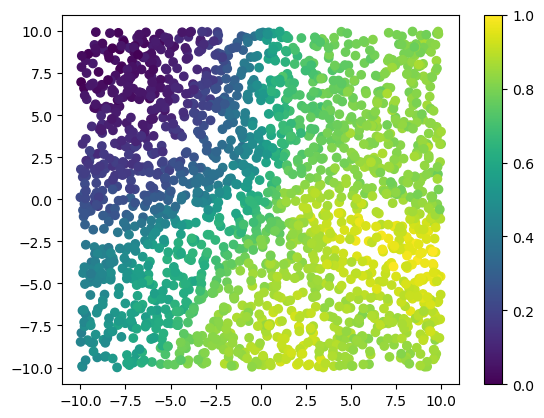

PyObject <matplotlib.colorbar.Colorbar object at 0x7f08b496eed0>

In [177]:
#---------------------------------------------------
#Generate Network Parameters and Corresponding Curve
#---------------------------------------------------
obs = choicemap()::ChoiceMap
obs[:l] = 3
#obs[(:k,1)] = 200
x_raw = rand(Uniform(-bound,bound),(N,d))
x = transpose(x_raw)
data = x
data_raw = x_raw

(trace,) = generate(generator, (), obs)

y_real = G(x,trace)[1,:]
y_real = [y_real[i] + normal(0.0,0.01) for i=1:length(y_real)]


dt = StatsBase.fit(UnitRangeTransform, y_real, dims=1, unit=true)
y_real = StatsBase.transform(dt, y_real)
#plot_surf(x_raw,y_real)
plot_data(x_raw,y_real)
#display(x_raw)

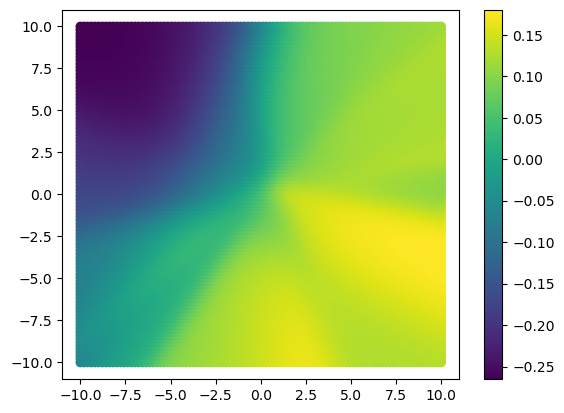

In [178]:
function creategrid(d::Integer, n::Integer, low::Float64, high::Float64)

    @assert d >= 1 ("d (number of dimensions) must be a positive integer")
    @assert n >= 2 ("n (number of points) must be a at least 2")

    r = range(low, high, length = n)

    iter = Iterators.product((r for _ in 1:d)...)

    return vec([collect(i) for i in iter])
end

grid = creategrid(2,100,-bound,bound)
grid_raw = reduce(hcat, getindex.(grid,i) for i in eachindex(grid[1]))
grid2 = transpose(grid_raw)
z = G(grid2,trace)[1,:]
plot_data(grid_raw, z);

In [155]:
#Classifier Network Tries to Learn the Generator Network

@gen function classifier(x::Array{Float64})
    #Prepare ChoiceMap to send through to BNN (G)
    obs = choicemap()::ChoiceMap

    #Draw number of layers
    l ~ categorical([1/length(l_list) for i=1:length(l_list)])
    l_real = l
    obs[:l] = l
    
    #Create individual weight and bias vectors
    #Loop through hidden layers
    k = [Int(0) for i=1:l]
    for i=1:l
        k[i] = @trace(categorical([1/length(k_list) for i=1:length(k_list)]), (:k,i))
        obs[(:k,i)] = k[i]
    end
    
    #Sample weight and parameter vectors
    W = [zeros(k[i]) for i=1:l]
    b = [zeros(k[i]) for i=1:l]
    for i=1:l
        if i == 1
            h = Int(d * k[i])
        else
            h = Int(k[i-1] * k[i])
        end

        μ = zeros(h)
        Σ = Diagonal([σₖ for i=1:length(μ)])
        W[i] = @trace(mvnormal(μ,Σ), (:W,i))
        obs[(:W,i)] = W[i]
        
        μ2 = ones(k[i])
        Σ2 = Diagonal([σₖ for i=1:length(μ2)])
        b[i] = @trace(mvnormal(μ2,Σ2), (:b,i))
        obs[(:b,i)] = b[i]
    end
    
    #Output Weights
    μₒ = zeros(k[l])
    Σₒ = Diagonal([σₖ for i=1:length(μₒ)])
    Wₒ ~ mvnormal(μₒ,Σₒ)
    obs[:Wₒ] = Wₒ
    
    #Output Bias
    μ2ₒ = ones(1)
    Σ2ₒ = Diagonal([σₖ for i=1:length(μ2ₒ)])
    bₒ ~ mvnormal(μ2ₒ,Σ2ₒ)
    obs[:bₒ] = bₒ
    
    scores = G(x,obs)
    scores = Flux.σ.(scores)
    
    #Regression Likelihood
    y = @trace(mvnormal(vec(scores), Diagonal([σᵧ for i=1:length(x[1,:])])), (:y))
    
    return y
end;

classifier(x);

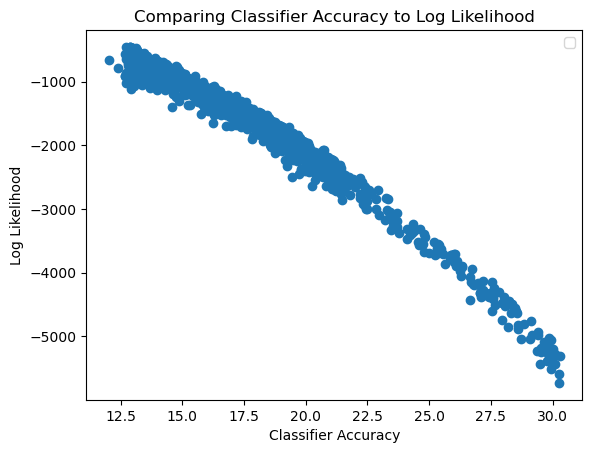

No handles with labels found to put in legend.


PyObject <matplotlib.legend.Legend object at 0x7f08b49df790>

In [179]:
#-----------------------------------------
#Register Observed Data - Test Likelihood
#-----------------------------------------

obs_master = choicemap()::ChoiceMap
obs_master[:y] = y_real
obs = obs_master;
obs[:l] = 5

scores = []
distances = []
ls = []
best_ls = []
best_traces = []
(best_trace,) = generate(classifier, (x,), obs)
best_score = get_score(best_trace)
best_l = best_trace[:l]

best_pred_y = Flux.σ.(G(x,best_trace))
best_dist = euclidean(best_pred_y, y_real)

function likelihood(best_trace, best_dist, best_score, best_l)
    obs = obs_master;
    (trace,) = generate(classifier, (x,), obs)
    pred_y = Flux.σ.(G(x,trace))

    dist = euclidean(pred_y, y_real)
    score = get_score(trace)
    #println(score)
    if dist < best_dist
        best_dist = dist
        best_score = score
        best_trace = trace
        best_pred_y = pred_y
        best_l = best_trace[:l]
    end
    #push!(best_ks,best_k)
    push!(scores,score)
    push!(distances,dist)
    #push!(ls, l)
    #println(best_score)
    return(best_trace, best_dist, best_score, best_l)
end;

for i=1:1000
    best_trace, best_dist, best_score, best_l = likelihood(best_trace, best_dist, best_score, best_l)
    push!(best_ls, best_l)
end

PyPlot.scatter(distances, scores)
plt.title("Comparing Classifier Accuracy to Log Likelihood")
plt.xlabel("Classifier Accuracy")
plt.ylabel("Log Likelihood")
#plt.ylim(-5000,2000)
plt.legend()

In [180]:
#-------------------------
#Layer Birth / Death Moves
#-------------------------

function layer_change(trace)
    current_l = trace[:l]
    if current_l == last(l_list)
        new_trace = layer_death(trace)
    elseif current_l == l_list[1]
        new_trace = layer_birth(trace)
    else
        new_trace = bernoulli(0.5) ? layer_birth(trace) : layer_death(trace)
    end
    return new_trace    
end

@gen function layer_birth(trace)
    
    previous_l = trace[:l]
    new_l = l_list[previous_l + 1]
    difference = abs(new_l - previous_l)
    
    #Where to insert new layer
    insert = rand((1:new_l))
    
    obs_new = choicemap()::ChoiceMap
    obs_new[:y] = y_real
    obs_new[:l] = new_l
    
    for i=1:new_l
        if i == insert
            obs_new[(:k,i)] = 1
        elseif i < insert
            obs_new[(:k,i)] = trace[(:k,i)]
        else
            obs_new[(:k,i)] = trace[(:k,i-1)]
        end
    end
    
    (new_trace, weight) = generate(classifier, (x,), obs_new)
    return new_trace
    
end

@gen function layer_death(trace)
    
    previous_l = trace[:l]
    new_l = l_list[previous_l - 1]
    difference = abs(new_l - previous_l)
    
    #Where to insert new layer
    delete = rand((1:previous_l))
    
    obs_new = choicemap()::ChoiceMap
    obs_new[:y] = y_real
    obs_new[:l] = new_l
    
    for i=1:new_l
        if i < delete
            obs_new[(:k,i)] = trace[(:k,i)]
        else
            obs_new[(:k,i)] = trace[(:k,i+1)]
        end
    end
    
    (new_trace, weight) = generate(classifier, (x,), obs_new)
    return new_trace
    
end;

function node_change(trace)
    current_l = trace[:l]
    layer = rand((1:current_l))
    #println("Proposed layer: $layer")
    current_k = trace[(:k, layer)]
    if current_k == last(k_list)
        new_trace = node_death(trace,layer)
    elseif current_k == k_list[1]
        new_trace = node_birth(trace,layer)
    else
        new_trace = bernoulli(0.5) ? node_birth(trace,layer) : node_death(trace,layer)
    end
    return new_trace        
end

@gen function node_birth(trace, layer)
    
    previous_k = trace[(:k,layer)]
    new_k = k_list[previous_k + 1]
    difference = abs(new_k - previous_k)
    
    #Select Insertion Place for New Neuron
    insert = rand((1:new_k))
    
    #Create new choicemap and fill with real Y values
    obs_new = choicemap()::ChoiceMap
    obs_new[:l] = trace[:l]
    obs_new[:y] = y_real
    
    #Fill k values in new ChoiceMap
    for i=1:trace[:l]
        if i == layer
            obs_new[(:k,i)] = new_k
        elseif i < layer
            obs_new[(:k,i)] = trace[(:k,i)]
        else
            obs_new[(:k,i)] = trace[(:k,i)]
        end
    end
    
    #Get the input and output dimensions of the edit layer
    in_dim, out_dim = layer_unpacker(layer,trace[:l],[obs_new[(:k,i)] for i=1:obs_new[:l]])
    
    for i=1:trace[:l]
        if i == layer
            obs_new[(:k,i)] = new_k
            W1 = [trace[(:W,i)][j] for j=1:length(trace[(:W,i)])]
            b1 = [trace[(:b,i)][j] for j=1:length(trace[(:b,i)])]
            for j=1:in_dim
                W1 = insert!(W1,insert+((j-1)*(out_dim)),normal(0,σₖ))
            end
            obs_new[(:W,i)] = W1
            obs_new[(:b,i)] = insert!(b1, insert, normal(1,σₖ))
            
            if layer == trace[:l]
                W2 = [trace[:Wₒ][j] for j=1:length(trace[:Wₒ])]
                obs_new[(:Wₒ)] = insert!(W2,insert,normal(0,σₖ))
                obs_new[(:bₒ)] = trace[:bₒ]
            else
                new_dim = obs_new[(:k,i+1)]
                W2 = [trace[(:W,i+1)][j] for j=1:length(trace[(:W,i+1)])]
                b2 = [trace[(:b,i+1)][j] for j=1:length(trace[(:b,i+1)])]
                for j=1:new_dim
                    W2 = insert!(W2,new_dim*(insert-1)+1,normal(0,σₖ))
                end
                obs_new[(:W,i+1)] = W2
                obs_new[(:b,i+1)] = b2
                obs_new[(:Wₒ)] = trace[:Wₒ]
                obs_new[(:bₒ)] = trace[:bₒ]
            end
            
        elseif i == layer + 1
            continue
        elseif i < layer
            obs_new[(:W,i)] = trace[(:W,i)]
            obs_new[(:b,i)] = trace[(:b,i)]
        else
            obs_new[(:W,i)] = trace[(:W,i)]
            obs_new[(:b,i)] = trace[(:b,i)]
        end
    end
    
    (new_trace, weight) = generate(classifier, (x,), obs_new)
    return new_trace
end

@gen function node_death(trace, layer)
    
    previous_k = trace[(:k,layer)]
    new_k = k_list[previous_k - 1]
    difference = abs(new_k - previous_k)
    
    #Select Insertion Place for New Neuron
    delete = rand((1:previous_k))
    #delete=5
    
    #Create new choicemap and fill with real Y values
    obs_new = choicemap()::ChoiceMap
    obs_new[:l] = trace[:l]
    obs_new[:y] = y_real
    
    #Fill k values in new ChoiceMap
    for i=1:trace[:l]
        if i == layer
            obs_new[(:k,i)] = new_k
        elseif i < layer
            obs_new[(:k,i)] = trace[(:k,i)]
        else
            obs_new[(:k,i)] = trace[(:k,i)]
        end
    end
    
    #Get the input and output dimensions of the edit layer
    in_dim, out_dim = layer_unpacker(layer,trace[:l],[obs_new[(:k,i)] for i=1:obs_new[:l]])
    
    for i=1:trace[:l]
        if i == layer
            obs_new[(:k,i)] = new_k
            W1 = [trace[(:W,i)][j] for j=1:length(trace[(:W,i)])]
            b1 = [trace[(:b,i)][j] for j=1:length(trace[(:b,i)])]
            for j=1:in_dim
                W1 = deleteat!(W1,delete+((j-1)*(out_dim)))
            end
            obs_new[(:W,i)] = W1
            obs_new[(:b,i)] = deleteat!(b1, delete)
            
            if layer == trace[:l]
                W2 = [trace[:Wₒ][j] for j=1:length(trace[:Wₒ])]
                obs_new[(:Wₒ)] = deleteat!(W2,delete)
                obs_new[(:bₒ)] = trace[:bₒ]
            else
                new_dim = obs_new[(:k,i+1)]
                W2 = [trace[(:W,i+1)][j] for j=1:length(trace[(:W,i+1)])]
                b2 = [trace[(:b,i+1)][j] for j=1:length(trace[(:b,i+1)])]
                for j=1:new_dim
                    W2 = deleteat!(W2,new_dim*(delete-1)+1)
                end
                obs_new[(:W,i+1)] = W2
                obs_new[(:b,i+1)] = b2
                obs_new[(:Wₒ)] = trace[:Wₒ]
                obs_new[(:bₒ)] = trace[:bₒ]
            end
            
        elseif i == layer + 1
            continue
        elseif i < layer
            obs_new[(:W,i)] = trace[(:W,i)]
            obs_new[(:b,i)] = trace[(:b,i)]
        else
            obs_new[(:W,i)] = trace[(:W,i)]
            obs_new[(:b,i)] = trace[(:b,i)]
        end
    end
    
    (new_trace, weight) = generate(classifier, (x,), obs_new)
    return new_trace
    
end;

In [185]:
#-------------------------
#RJMCMC - Layers and Nodes
#-------------------------

traces = []
acc = []
acc_a = []
acc_w = []
acc_l = []
ls = []
epss = []

function within_move(trace, iters)
    for i=1:iters
        eps = uniform(0.015,0.1)
        (trace, accepted) = hmc(trace, select(:Wₕ,:bₕ,:Wₒ,:bₒ), L=10, eps=eps, check=false, observations=obs)
        push!(traces, trace)
        push!(acc, accepted)
        push!(acc_w, accepted)
        #accepted && println("Within accepted")
    end
    return trace
end

function node_move(trace, iters, obs)
    
    new_trace = node_change(trace)
    score_test = get_score(new_trace)
    
    test = true
    for i=1:iters
        eps = uniform(0.0015,0.01)
        (new_trace, accepted) = hmc(new_trace, select(:Wₕ,:bₕ,:Wₒ,:bₒ), L=10, eps=eps, check=false, observations=obs)
        #accepted && (test = false)
    end
    #test && println("Nothing accepted")
    
    score1 = get_score(trace)
    score2 = get_score(new_trace)
    
    logscore = (score2 - score1)
    score = exp(logscore)

    #println("Old Trace: $score1; Pre-HMC: $score_test; Post-HMC: $score2")
    if rand(Uniform(0,1)) < score
        accepted = true
        trace = new_trace
        new_k = [trace[(:k,i)] for i=1:trace[:l]]
        #println("New ks accepted! Current ks: $(new_k)")
    else
        #println("Sticking with the old k!")
        accepted = false
    end
    
    #obs = obs_master
    #for i=1:trace[:l]
        #obs[(:k,i)] = trace[(:k,i)]
    #end
        
    push!(traces, trace)
    push!(acc, accepted)
    push!(acc_a, accepted)
    return trace
end

function layer_move(trace, iters, obs)
    new_trace = layer_change(trace)
    score_test = get_score(new_trace)
    
    test = true
    for i=1:iters
        eps = uniform(0.0015,0.01)
        (new_trace, accepted) = hmc(new_trace, select(:Wₕ,:bₕ,:Wₒ,:bₒ), L=10, eps=eps, check=false, observations=obs)
        #accepted && (test = false)
    end
    #test && println("Nothing accepted")
    
    score1 = get_score(trace)
    score2 = get_score(new_trace)
    
    logscore = (score2 - score1)
    score = exp(logscore)

    println("Old Trace: $score1; Pre-HMC: $score_test; Post-HMC: $score2")
    
    if rand(Uniform(0,1)) < score
        accepted = true
        trace = new_trace
        new_k = trace[:l]
        #println("New l accepted! Current l: $(new_k)")
    else
        #println("Sticking with the old k!")
        accepted = false
    end
    
    obs = obs_master
    obs[:l] = trace[:l]
    for i=1:trace[:l]
        obs[(:k,i)] = trace[(:k,i)]
    end
        
    push!(traces, trace)
    push!(acc, accepted)
    push!(acc_l, accepted)
    return trace , obs[:l]
    
end

function rjmcmc(starting_trace, iters)
    trace = starting_trace
    l = trace[:l]
    ks = [trace[(:k,i)] for i=1:trace[:l]]
    println("Beginning RJMCMC. Starting l: $l")
    println("Starting ks: $ks")
    println("--------------------------------")
    #@showprogress 1 "Sampling..." for i = 1:iters
    for i=1:iters
        l = trace[:l]
        ks = [trace[(:k,i)] for i=1:trace[:l]]
        #x_samp, y_samp = sample_data(x, y_real)
        #x_samp = transpose(x_samp)
        obs_master = choicemap()::ChoiceMap
        obs_master[:y] = y_real
        obs = obs_master;
        if i%5 == 0
            #println("Epoch $i Acceptance Prob: $(sum(acc)/length(acc))")
            #println("Epoch $i layer count: $l, ks: $ks")
            #println("Epoch $i Within Acceptance Prob: $(sum(acc_w)/length(acc_w))")
            #println("Epoch $i Across Acceptance Prob: $(sum(acc_a)/length(acc_a))")
            #println("Epoch $i Layer Acceptance Prob: $(sum(acc_l)/length(acc_l))")
            println([trace[(:k,i)] for i=1:trace[:l]])
        end
        
        #Indicator variable for move type
        u = rand(Uniform(0,1))
        if u > 0.95
            (trace, l) = layer_move(trace, 10, obs)
        elseif u > 0.5
            (trace) = node_move(trace, 1, obs)
        else
            (trace) = within_move(trace, 1)
        end
        push!(ls, l)
    end
    println("Finished")
end
 
runs = 5000
#starting_trace = best_trace

#x_samp, y_samp = sample_data(x, y_real)
#x_samp = transpose(x_samp)
obs_master = choicemap()::ChoiceMap
obs_master[:y] = y_real
obs = obs_master
#(starting_trace,) = generate(classifier, (x,), obs)
#starting_trace = best_trace2
obs[:l] = starting_trace[:l]

rjmcmc(starting_trace,runs);

Beginning RJMCMC. Starting l: 2
Starting ks: [10, 8]
--------------------------------
[10, 8]
[10, 8]
[10, 6]
[8, 6]
[8, 6]
[8, 6]
[8, 6]
Old Trace: 1405.6250388263663; Pre-HMC: -7392.615333604184; Post-HMC: -2462.422602688665
[8, 6]
[8, 6]
[8, 6]
[8, 6]
[8, 6]
[9, 6]
[9, 6]
[9, 6]
[10, 6]
[9, 6]
Old Trace: 1849.5338595000542; Pre-HMC: -19144.621403633246; Post-HMC: 1706.2427142406264
[9, 6]
[9, 6]
[9, 6]
[10, 6]
[10, 7]
[10, 7]
[10, 7]
[10, 7]
[10, 7]
[10, 7]
[10, 7]
[9, 7]
[9, 7]
[9, 7]
[9, 7]
[9, 8]
[9, 8]
[10, 7]
Old Trace: 2068.606707054608; Pre-HMC: -5750.790137242004; Post-HMC: -5396.992034404785
[11, 7]
[12, 7]
Old Trace: 2123.1469822649133; Pre-HMC: -15264.26318871352; Post-HMC: -5602.038899993677
[12, 7]
[12, 7]
[12, 7]
[12, 6]
[12, 6]
[12, 6]
[12, 6]


InterruptException: InterruptException:

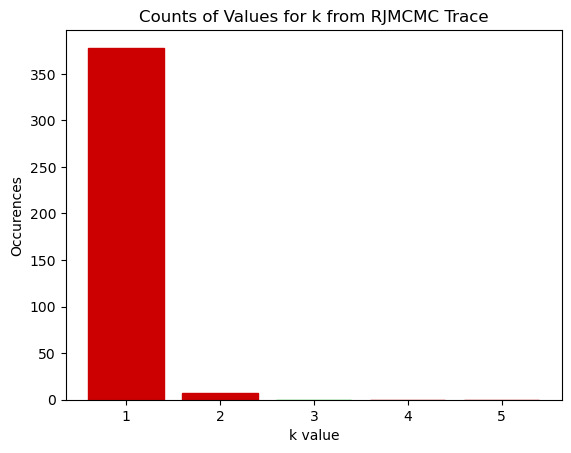

In [95]:
#Bar Plot of k estimates
counts = [sum([ls[i] == j for i in 1:length(ls)]) for j in l_list]
barlist=PyPlot.bar(l_list,counts)
for i in 1:l_range
    barlist[i].set_color([0.8,0.0,0.0])
end
barlist[l_real].set_color([0.0,0.8,0.1])

plt.title("Counts of Values for k from RJMCMC Trace")
plt.xlabel("k value")
plt.ylabel("Occurences");

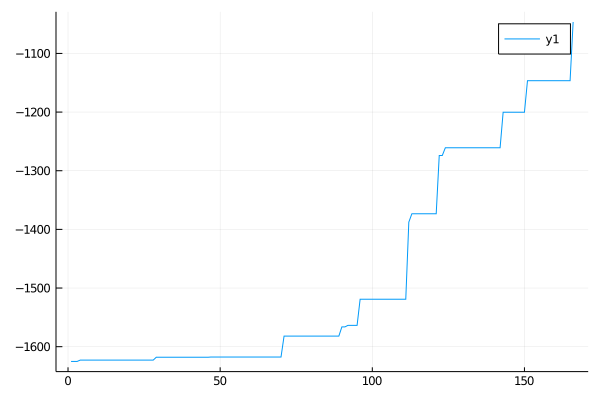

In [90]:
#Scores Plot
scores = [get_score(traces[i]) for i=1:length(traces)]
Plots.plot(scores[50:length(scores)])

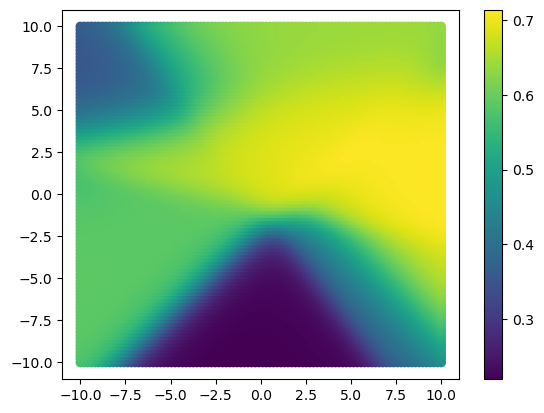

-1486.8470818800345
-1486.8021540942013
-1472.9523232898523
-1461.6528555085874
-1450.794695653835
-1441.7261262779323
-1358.1488233042223
-1286.982946384608
-1234.7178544521962
-1234.400128581768
-1229.372238324444
-1229.2509473244827
-1212.8378127868186
-1212.4401939340369
-1205.6833638560038
-1183.4242111436704
-1183.1481004933466
-1182.9961963079577
-1174.575930993334
-1174.3294167304775
-1174.1548703240755
-1173.9145857090418
-1161.7585596157123
-1161.2804709882853
-1161.2344429055051
-1146.563266085285
-1145.4129632103616
-1143.722894745969
-1143.6587026362342
-1143.6246911914552
-1128.2484206478698
-1128.006908186525
-1126.0234938556923
-790.600292896388
-769.5399771590608
-766.1864783287787
-766.0716878188675
-685.3757189296338
-679.60473656325
-679.3621128022819
-665.833412672579
-665.4410433260682
-665.3667469453309
-665.3651692827732
-578.9015216483517
-578.8355076140737
-578.8240396781977
-574.5522344560568
-573.0215048902978
-572.9723983167386
-569.916268371851
-568.889949

PyObject <matplotlib.colorbar.Colorbar object at 0x7f08c03cc810>

In [64]:
#Best Guess
best_i = 1
for i=1:length(traces)
    test_trace = traces[i]
    test_score = get_score(test_trace)
    if test_score > get_score(traces[best_i]) 
        best_i = i
        println(test_score)
    end
    #println("Epoch $i Score: $test_score")
end

print(best_i)
best_trace = traces[best_i];

function tracegrid(trace, low=-bound, high=bound)
    d=2
    n=100
    r = range(low, high, length = n)

    iter = Iterators.product((r for _ in 1:d)...)
    grid= vec([collect(i) for i in iter])
    grid_raw = reduce(hcat, getindex.(grid,i) for i in eachindex(grid[1]))
    grid2 = transpose(grid_raw)
    z = Flux.σ.(G(grid2,trace))[1,:]
    plot_data(grid_raw, z)
end

tracegrid(traces[best_i])

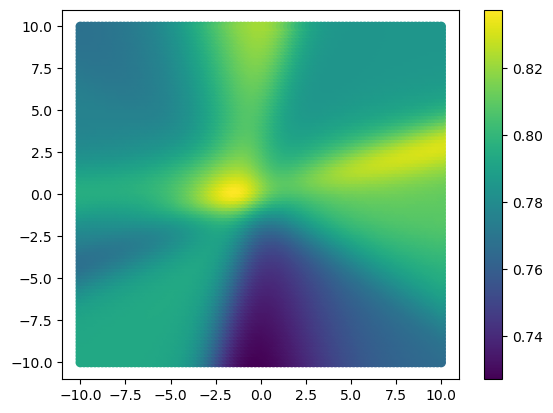

In [65]:
function creategrid(d::Integer, n::Integer, low::Float64, high::Float64)

    @assert d >= 1 ("d (number of dimensions) must be a positive integer")
    @assert n >= 2 ("n (number of points) must be a at least 2")

    r = range(low, high, length = n)

    iter = Iterators.product((r for _ in 1:d)...)

    return vec([collect(i) for i in iter])
end

grid = creategrid(2,100,-bound,bound)
grid_raw = reduce(hcat, getindex.(grid,i) for i in eachindex(grid[1]))
grid2 = transpose(grid_raw)
z = G(grid2,trace)[1,:]
plot_data(grid_raw, z);

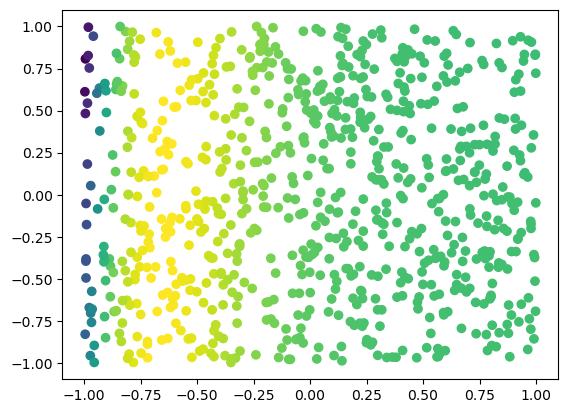

PyObject <matplotlib.collections.PathCollection object at 0x7f5af5d23d50>

In [523]:
best_i = 1
for i=1:length(traces)
    test_trace = traces[i]
    test_score = get_score(test_trace)
    if test_score > get_score(traces[best_i]) 
        best_i = i
        #print(test_score)
    end
    #println("Epoch $i Score: $test_score")
end

Q = 1000
y_prime = zeros(length(y_real))

for j=1:Q
    rand_i = rand((1:length(traces)))
    trace_now = traces[rand_i]

    y_test = Flux.σ.(G(x,trace_now)[1,:])
    y_prime += y_test .* (1/Q)
    #println(euclidean(y_test, y_real))
end

plot_data(x_raw,y_prime)

In [410]:
obs = choicemap()::ChoiceMap
obs[:y] = y_real
(trace1, weight) = generate(classifier, (x,), obs)
println(trace1[:l])
println([trace1[(:k,i)] for i=1:trace1[:l]])

2
[5, 2]


In [443]:
obs_test = node_death(trace1,2)
#for i = 1:obs_test[:l]
    #k_value = obs_test[(:k,i)]
    #println("New K value: $k_value")
    #println("Old Layer $i")
    #println(length(trace1[(:W,i)]))
    #println(length(trace1[(:b,i)]))
    #println("New Layer $i")
    #println(length(obs_test[(:W,i)]))
    #println(length(obs_test[(:b,i)]))
#end

#println("Old Layer1")
#println(trace1[(:W,1)])
#println("New Layer1")
#println(obs_test[(:W,1)])

println("Old Layer2")
println(trace1[(:W,2)])
println("New Layer2")
println(obs_test[(:W,2)])

println("Old Output")
println(trace1[:Wₒ])
println("New Output")
println(obs_test[:Wₒ])
#println(obs_test[:l])
#println([trace2[(:k,i)] for i=1:trace2[:l]])
#println(trace1[(:W,2)])
#println(trace2[(:W,2)])

Old Layer2
[0.6944355196259376, -2.810241319289477, -2.133252299513039, -4.52977394133533, -0.3976172543464647, 5.664750269389079, 2.0310273089456405, 10.733702852833334, 8.845678615207417, -9.531959140772516]
New Layer2
[0.6944355196259376, -2.133252299513039, -0.3976172543464647, 2.0310273089456405, 8.845678615207417]
Old Output
[5.745862179773199, -3.4917019115837507]
New Output
[5.745862179773199]


In [329]:
in_dim, out_dim = layer_unpacker(2, trace1[:l], [trace1[(:k,i)] for i=1:trace1[:l]])
W = reshape(trace1[(:W,2)], out_dim, in_dim)
display(W)
#b = reshape(trace[(:b,i)], trace[(:k,i)])

in_dim2, out_dim2 = layer_unpacker(2, obs_test[:l], [obs_test[(:k,i)] for i=1:obs_test[:l]])
W2 = reshape(obs_test[(:W,2)], out_dim2, in_dim2)
display(W2)

2×4 Array{Float64,2}:
 -2.39915  -9.68362  3.97276  -6.56801
  6.10672  -4.81245  9.96185   2.30547

2×5 Array{Float64,2}:
 -2.39915  -9.68362   28.3822  3.97276  -6.56801
  6.10672  -4.81245  -46.4873  9.96185   2.30547

In [309]:
in_dim, out_dim = layer_unpacker(3, trace2[:l], [trace2[(:k,i)] for i=1:trace2[:l]])
println(trace2[(:W,3)])
W = reshape(trace2[(:W,3)], out_dim, in_dim)

MethodError: MethodError: no method matching getindex(::Nothing, ::Symbol)

In [67]:
obs = choicemap()::ChoiceMap
obs[:y] = y_real
(trace1, weight) = generate(classifier, (x,), obs)
println(trace1[:l])
println([trace1[(:k,i)] for i=1:trace1[:l]])

if trace1[:l] != 5
    trace2 = layer_birth(trace1)
    println(trace2[:l])
    println([trace2[(:k,i)] for i=1:trace2[:l]])
end

1
[7]
2
[1, 7]


In [162]:
obs = choicemap()::ChoiceMap
obs[:y] = y_real
(trace1, weight) = generate(classifier, (x,), obs)
println(trace1[:l])
println([trace1[(:k,i)] for i=1:trace1[:l]])

if trace1[:l] != 1
    trace2 = layer_death(trace1)
    println(trace2[:l])
    println([trace2[(:k,i)] for i=1:trace2[:l]])
end

3
[2, 6, 1]
2
[2, 6]


In [184]:
a = [1, 2, 3, 4, 5]
insert!(a, 1, 6)
insert!(a, 1, 7)

7-element Array{Int64,1}:
 7
 6
 1
 2
 3
 4
 5

In [48]:
    #Fill k values in new ChoiceMap
    for i=1:new_l
        if i == layer
            obs_new[(:k,i)] = new_k
            W1 = [trace[(:W,i)][j] for j=1:length(trace[(:W,i)])]
            b1 = [trace[(:b,i)][j] for j=1:length(trace[(:b,i)])]
            for j=1:
                obs_new[(:W,i)] = insert!
            end
            obs_new[(:b,i)] = insert!(b1, insert, normal(1,σₖ))
            if layer == last(l_list)
                W2 = [trace[:Wₒ][j] for j=1:length(trace[:Wₒ])]
                b2 = [trace[:bₒ][j] for j=1:length(trace[:bₒ])]
            else
                W2 = [trace[(:W,i)][j] for j=1:length(trace[(:W,i)])]
                b2 = [trace[(:b,i)][j] for j=1:length(trace[(:b,i)])]
            end
                
                
            

        elseif i < insert
            obs_new[(:k,i)] = trace[(:k,i)]
        else
            obs_new[(:k,i)] = trace[(:k,i-1)]
        end
    end
    
    #Adjust parameter vectors
    #obs_new[:Wₕ] = vcat(Wₕ,[normal(0,σₖ) for i=1:(2*difference)])
    #Wₕ = insert!(Wₕ, insert*2-1, normal(0,σₖ))
    #obs_new[:Wₕ] = insert!(Wₕ, insert*2, normal(0,σₖ))
    #obs_new[:Wₒ] = insert!(Wₒ, insert, normal(0,σₖ))
    #obs_new[:bₕ] = insert!(bₕ, insert, normal(1,σₖ))
    #obs_new[:bₒ] = bₒ

    #bs_new[:Wₕ] = vcat(Wₕ,[normal(0,σₖ) for i=1:(2*difference)])
    #obs_new[:Wₒ] = vcat(Wₒ,[normal(0,σₖ) for i=1:difference])
    #obs_new[:bₕ] = vcat(bₕ,[normal(1,σₖ) for i=1:difference])
    #obs_new[:bₒ] = bₒ
    #obs_new[:k] = new_k
    
    #(new_trace, weight) = generate(classifier, (x_samp,), obs_new)
    #return new_trace

DynamicChoiceMap(Dict{Any,Any}((:k, 2) => 2,(:k, 1) => 2,:y => [0.999999992622026, 0.9999999905987488, 0.9999999803771195, 0.9999999816695239, 0.9999999857041912, 0.9999999867586842, 0.9999999788483962, 0.9999999926057754, 0.9999999828096252, 0.9999999820866253, 0.9999999954406738, 0.9999999828677114, 0.9999999951975942, 0.9999999828784617, 0.9999999803021445, 0.9999999830941079, 0.9999999838779201, 0.9999999828715799, 0.9999999884242604, 0.9999999961286714, 0.9999999843397325, 0.9999999955665917, 0.9999999830963969, 0.9999999769765203, 0.9999999754529073, 0.9999999950814995, 0.9999999878975473, 0.9999999828760612, 0.9999999789811278, 0.9999999911926846, 0.9999999857754074, 0.9999999839535494, 0.9999999827678182, 0.9999999829576122, 0.999999996015152, 0.9999999926492289, 0.9999999829335003, 0.9999999913716017, 0.9999999759953392, 0.9999999805979786, 0.9999999947975833, 0.9999999900128916, 0.999999995949544, 0.9999999880990597, 0.9999999924902724, 0.9999999827385176, 0.9999999828534648,

 0.9999999827653697, 0.9999999807141021, 0.9999999826344922, 0.9999999814323329, 0.9999999832787917, 0.999999980879616, 0.9999999961213808, 0.999999993674672, 0.9999999909743303, 0.9999999787127225, 0.9999999893744903, 0.9999999768601607, 0.9999999944263471, 0.9999999762477326, 0.9999999959033015, 0.9999999728956225, 0.9999999886970771, 0.9999999936392094, 0.9999999824003664, 0.9999999828766105, 0.9999999950336225, 0.999999992099207, 0.9999999828716662, 0.9999999794252012, 0.9999999830196288, 0.999999982871918, 0.999999970985433, 0.9999999957742784, 0.9999999899538196, 0.9999999702690934, 0.9999999957645089, 0.9999999826521243, 0.9999999830442748, 0.9999999823117874, 0.9999999828607692, 0.9999999828610283, 0.999999981283804, 0.9999999902317712, 0.9999999829340517, 0.9999999930809409, 0.9999999828793621, 0.9999999828597511, 0.9999999731920384, 0.9999999959412134, 0.9999999959349608, 0.9999999892613493, 0.9999999827492877, 0.9999999841868161, 0.9999999760117301, 0.9999999915287988, 0.999